<a href="https://colab.research.google.com/github/hossein20s/kwh_prediction/blob/master/kwh_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition
Check it out from 
https://docs.google.com/document/d/1-ceuHfJ2bNbgmKddLTUCS0HJ1juE5t0042Mts_yEUD8v

# Connecting Colab to GDrive
Connecting colab to GDrive as I kept the data there

In [0]:
!pip install fbprophet
!pip install pystan

In [4]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/data" data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


# DATA & SRC Acquisition
Checking out the code from Github

In [0]:
!wc -l data/load_temperature_data.csv

45506 data/load_temperature_data.csv


In [0]:
!git clone https://github.com/hossein20s/kwh_prediction
!cd kwh_prediction; git pull
import sys
sys.path.append('kwh_prediction')
import importlib
import power_predictor
importlib.reload(power_predictor)

# Data Exploration
some OS level cehcking the data size 

Conver it to Pandas Dataframe, check its shape a normalize it and add proper column names and index. All dont in __init__ method of class

In [0]:
import pandas as pd
from power_predictor import PowerForecaster, Models, Constants, ColumnNames
from test_power_predictor import TestPowerForecaster

DATA_FILE = 'data/load_temperature_data.csv'
df = pd.read_csv(DATA_FILE)


In [0]:

import logging

logFormatter = logging.Formatter("%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s")
rootLogger = logging.getLogger()
consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logFormatter)
rootLogger.addHandler(consoleHandler)
rootLogger.setLevel(logging.INFO)


# Initialize
For first time it takes some time maybe 5 minutes. However it saves the resultant interpolated data in a file and sebsequent runs will be pretty fast

In [8]:
powerForecaster = PowerForecaster(df, model=Models.LSTM,
                                     upsample_freq='8H')


INFO:root:resample: 8H. future_prediction: 21, epochs: 100, batch_size: 20, window_size: 30, eurons: 30
2019-09-23 02:31:59,136 [MainThread  ] [INFO ]  resample: 8H. future_prediction: 21, epochs: 100, batch_size: 20, window_size: 30, eurons: 30
INFO:numexpr.utils:NumExpr defaulting to 2 threads.
2019-09-23 02:31:59,216 [MainThread  ] [INFO ]  NumExpr defaulting to 2 threads.


First 3 rows:                   Unnamed: 0  actual_kwh  ...  dow month
0  2012-11-01 01:00:00-07:00         NaN  ...    3    11
1  2012-11-01 01:15:00-07:00         NaN  ...    3    11
2  2012-11-01 01:30:00-07:00         NaN  ...    3    11

[3 rows x 7 columns]
____________________________________________________________________________________________________
First element Unnamed: 0            2012-11-01 01:00:00-07:00
actual_kwh                                  NaN
actual_temperature                         60.1
date                                 2012-11-01
time                                   01:00:00
dow                                           3
month                                        11
Name: 0, dtype: object
____________________________________________________________________________________________________
Last element Unnamed: 0            2014-02-18 00:00:00-08:00
actual_kwh                                  NaN
actual_temperature                           52
date

kwh_prediction/power_predictor.py:137: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



# Visual Inspection and Sanity Check

Seasional and Hour of day patterns can be seen in the data. We interpolated temperature using Facebook Prophet package

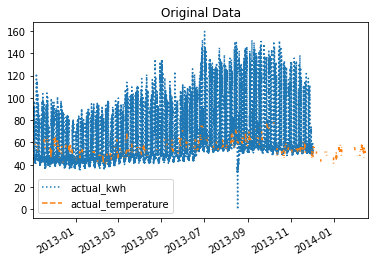

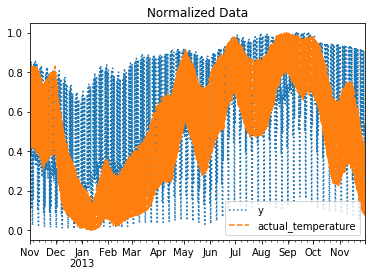

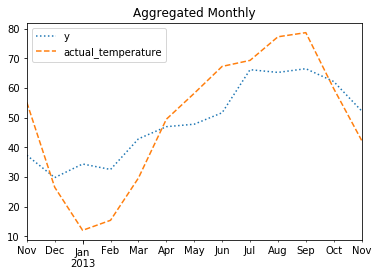

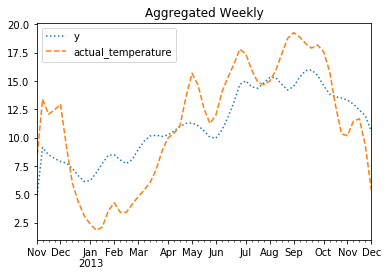

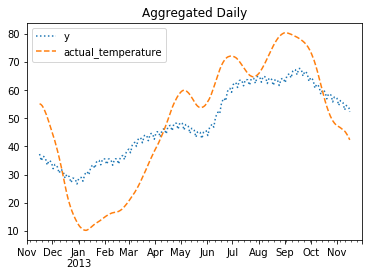

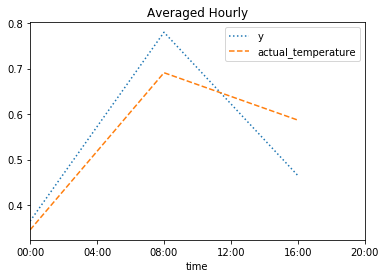

In [9]:
powerForecaster.visual_inspection()

# Applying LSTM 
To predict from both past kwh and temperature

In [10]:
# First we block some part from both training and validation. Consider it for testing
powerForecaster.block_after_date("2013-06-01")

INFO:root:Blocked from 2013-06-01 00:00:00 to 2013-11-30 16:00:00 fromo training and validation
2019-09-23 02:32:15,719 [MainThread  ] [INFO ]  Blocked from 2013-06-01 00:00:00 to 2013-11-30 16:00:00 fromo training and validation


In [11]:
powerForecaster.adjust_index_and_training_shift(start_date_in_labeling_st="2012-11-02")
# This is the main core of code that creates trainig, vaidation, shuffling and sliding window
powerForecaster.sliding_window()

INFO:root:Shift is set to be 3
2019-09-23 02:32:18,445 [MainThread  ] [INFO ]  Shift is set to be 3
INFO:root:length of data reduced by 549 due to blocking. The last date is 2013-05-15 00:00:00
2019-09-23 02:32:20,105 [MainThread  ] [INFO ]  length of data reduced by 549 due to blocking. The last date is 2013-05-15 00:00:00


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2019-09-23 02:32:25,162 [MainThread  ] [WARNI]  From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6, 10)             410       
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 30)             4920      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 12,681
Trainable params: 12,681
Non-trainable params: 0
_________________________________________________________________
None


2019-09-23 02:32:34,673 [MainThread  ] [WARNI]  Method (on_train_batch_end) is slow compared to the batch update (0.132122). Check your callbacks.



....................................................................................................

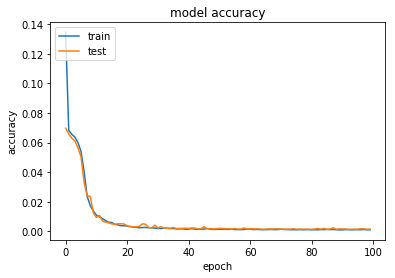

In [12]:
# Fitting and plotting the erros
powerForecaster.fit()
powerForecaster.plot_history()

In [13]:
powerForecaster.evaluate()

INFO:root:Metric names:['loss', 'mean_absolute_error']
2019-09-23 02:34:04,210 [MainThread  ] [INFO ]  Metric names:['loss', 'mean_absolute_error']
INFO:root:Loss Metrics:[0.0016269121840436999, 0.030743623]
2019-09-23 02:34:04,212 [MainThread  ] [INFO ]  Loss Metrics:[0.0016269121840436999, 0.030743623]


INFO:root:Predicting time slice [2013-06-01 00:00:00 : 2013-07-01 00:00:00] from [2013-05-31 00:00:00 : 2013-06-30 00:00:00]
2019-09-23 02:34:07,685 [MainThread  ] [INFO ]  Predicting time slice [2013-06-01 00:00:00 : 2013-07-01 00:00:00] from [2013-05-31 00:00:00 : 2013-06-30 00:00:00]


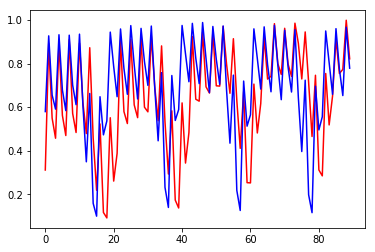

kwh_prediction/power_predictor.py:228: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [14]:
model = powerForecaster.model_type.value
# picking the slide from the blocked area to predict 
x = powerForecaster.lstm_predict(model,
                                     start_date_to_predict_st="2013-6-01",
                                                    duration_in_freq=3 * 30
                                                    )
     

# Model 1: Facebook Prophet 

In [0]:
.fit()
print("done fitting, forecasting ...")
predicted = forecaster.predict()

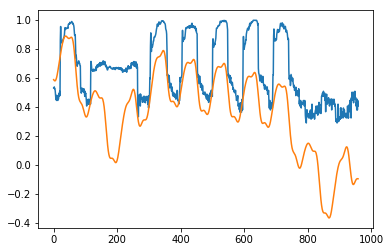

In [0]:
forecaster.plot_prediction(predicted)

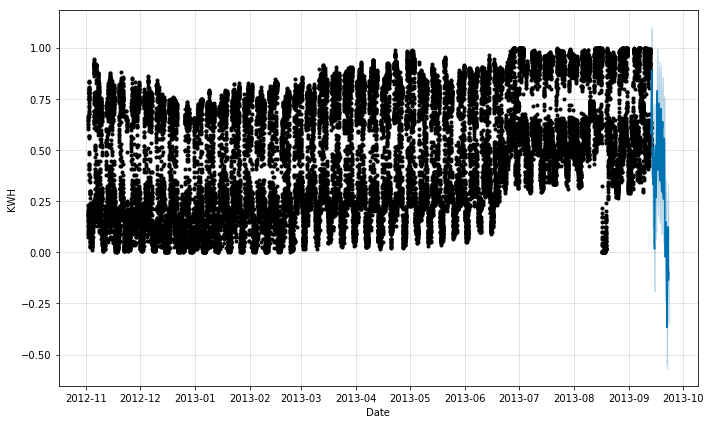

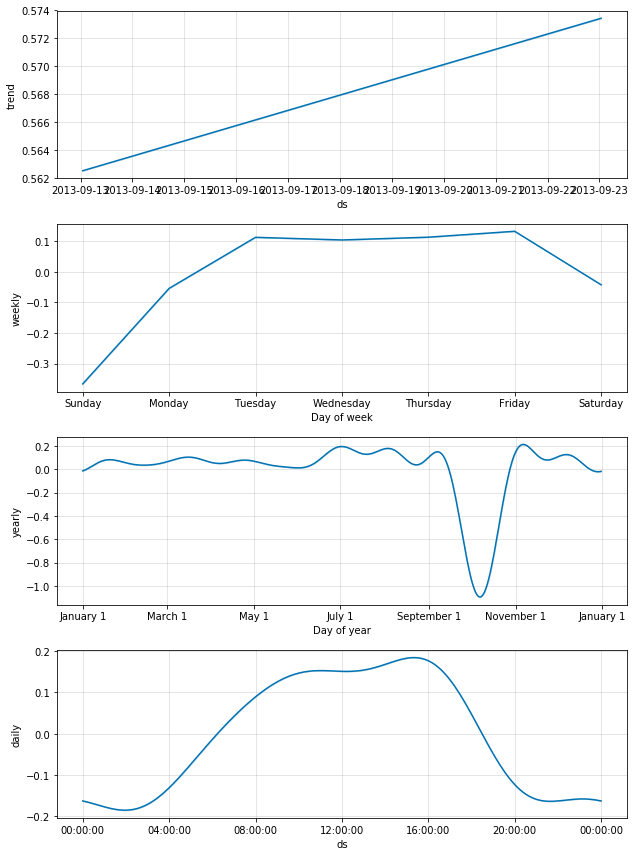

In [0]:
forecaster.plot_future(predicted)

# Model 2: ARIMA

In [0]:
forecaster.model = Models.ARIMA
forecaster.fit()
print("fitted")
predictor = forecaster.predict()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMAX fitting ....


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



SARIMAX forecast 30336    0.52654
dtype: float64
fitted
2013-09-03 01:00:00 2013-09-13 00:45:00


(960, 23)


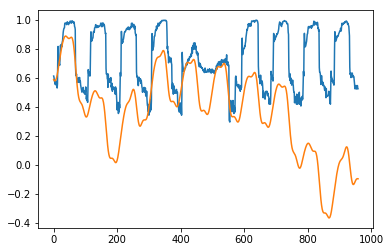

In [0]:
print(predicted.shape)
import matplotlib.pyplot as plt

plt.plot(predicted.index, forecaster.train_y['y'].iloc[-960:], predicted['y'])
plt.show()

# Model 3: VAR (Multivariat)

In [0]:
powerForecaster = PowerForecaster(df, model=Models.VAR)


In [0]:
powerForecaster.fit()

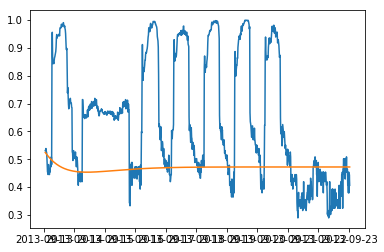

In [0]:
#print(predicted)
forecaster.plot_prediction(predicted)

# Model 4: LSTM

In [0]:
forecaster.model = Models.LSTM
forecaster.sliding_window()
print("Done sliding")
forecaster.fit()

Random shuffeling
sliding window length 37916
Done sliding


ValueError: ignored

In [0]:
forecaster.stationary_test()


array([0.04886238, 0.00424556])

In [0]:
print(forecaster.history.keys())

import matplotlib.pyplot as plt

plt.plot(forecaster.history['loss'])
plt.plot(forecaster.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


*  Take a look at the first couple of lines 
*  If it has any missing data: *It didn’t*
*  Some statistics on the df: *Sparse data*




**Find out the size of not null data**